# Forecasting National Electricity Load  (nat_demand) Using Electricity Load Forecasting Data Set

Context

This is a useful dataset to train and test Machine Learning forecasting algorithms and compare results with the official forecast from weekly pre-dispatch reports. The following considerations should be kept to compare forecasting results with the weekly pre-dispatch forecast:

Saturday is the first day of each weekly forecast; for instance, Friday is the last day.
A 72 hours gap of unseen records should be considered before the first day to forecast. In other words, next week forecast should be done with records until each Tuesday last hour.
Data sources provide hourly records.

The data composition is the following:

Historical electricity load, available on daily post-dispatch reports, from the grid operator (CND).
Historical weekly forecasts available on weekly pre-dispatch reports, both from CND.
Calendar information related to school periods, from Panama's Ministery of Education.
Calendar information related to holidays, from "When on Earth?" website.
Weather variables, such as temperature, relative humidity, precipitation, and wind speed, for three main cities in Panama, from Earthdata.



In the following sections of this Jupyter Notebook, we will delve into data wrangling, exploratory data analysis, and model building using this rich dataset.


**1. Sourcing and loading**
- Load relevant libraries
- Load the data
- Explore the data


**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Analyzed the ACF for each feature
- Plot the Pie chart and bar chart
  
  
**3. Modelling**
- Augmented Dickey-Fuller Test
- Train-Test Split
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Exponential Smoothing Model
- The SARIMAX model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding**
- What is our conclusion?
- Next steps
    


### Importing Required Libraries for Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
from datetime import datetime, timedelta

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading the data

In [5]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/continuous_dataset.csv')

# Replace 'NULL' with NaN
df.replace('NULL', np.nan, inplace=True)

# Convert columns to appropriate data types
df['datetime'] = pd.to_datetime(df['datetime'])

# Now df is your DataFrame with the data


### Initial Data Check

In [13]:
df

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
48044,2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
48045,2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1
48046,2020-06-26 23:00:00,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,23.601862,0.018358,0.152771,3.138132,0,0,1


In [15]:
# Get the unique values and their counts
value_counts = df['Holiday_ID'].value_counts()

# Display the result
print(value_counts)

Holiday_ID
0     45024
12      168
2       144
4       144
5       144
6       144
3       144
7       144
8       144
10      144
9       144
11      144
1       144
19      144
16      144
21      144
15      120
13      120
14      120
18      120
17      120
20      120
22      120
Name: count, dtype: int64


In [16]:
# Get the unique values and their counts
value_counts = df['holiday'].value_counts()

# Display the result
print(value_counts)


holiday
0    45024
1     3024
Name: count, dtype: int64


Holiday data seems okay, I checked whether all the values in the columns were the same.

### Checking the size of the data

In [7]:
df.shape

(48048, 17)

### Dealing Missing Values

In [8]:
df.isnull().sum()

,0
datetime,0
nat_demand,0
T2M_toc,0
QV2M_toc,0
TQL_toc,0
W2M_toc,0
T2M_san,0
QV2M_san,0
TQL_san,0
W2M_san,0


We do not have any missing values hence we do not have to replace any value with zeros in specified columns.

# Electricity Balance Data Variables

The DataFrame `df` contains several variables related to electricity data. Here's a breakdown of each variable:

## Variables

1. datetime: Time in Coordinated Universal Time (UTC) for each data entry.
2. nat_demand: National electricity load
3. T2M: Temperature at 2 meters
4. QV2M: Relative humidity at 2 meters
5. TQL: Liquid precipitation
6. W2M: Wind speed at 2 meters

And after the underscore is the city

7. toc: Tocumen, Panama city
8. san: Santiago city
9. dav: David city

The rest of variables:

10. Holiday_ID: Unique identification number integer
11. holiday: Holiday binary indicator (1=holiday, 0=regular day)
12. school: School period binary indicator (1=school, 0=vacations)

Each variable is crucial for understanding the dynamics of electricity balance in the dataset, including aspects of production, consumption, and exchange.


### Elimination of Redundant Columns

There seems to be no redundant column. Let's skip this part.

### Setting Data Frequency to Hourly

In [27]:

# Resample the data to ensure an hourly frequency
df = df.resample('H').sum()

# Set the frequency of the index explicitly (optional)
df.index.freq = 'H'

# Display the resampled DataFrame
print(df.head())



                     nat_demand    T2M_toc  QV2M_toc   TQL_toc    W2M_toc  \
datetime                                                                    
2015-01-03 01:00:00    970.3450  25.865259  0.018576  0.016174  21.850546   
2015-01-03 02:00:00    912.1755  25.899255  0.018653  0.016418  22.166944   
2015-01-03 03:00:00    900.2688  25.937280  0.018768  0.015480  22.454911   
2015-01-03 04:00:00    889.9538  25.957544  0.018890  0.016273  22.110481   
2015-01-03 05:00:00    893.6865  25.973840  0.018981  0.017281  21.186089   

                       T2M_san  QV2M_san   TQL_san    W2M_san    T2M_dav  \
datetime                                                                   
2015-01-03 01:00:00  23.482446  0.017272  0.001855  10.328949  22.662134   
2015-01-03 02:00:00  23.399255  0.017265  0.001327  10.681517  22.578943   
2015-01-03 03:00:00  23.343530  0.017211  0.001428  10.874924  22.531030   
2015-01-03 04:00:00  23.238794  0.017128  0.002599  10.518620  22.512231   
2015

### Converting Numeric Values to Appropriate Formats

In [28]:
# Display the column names
print(df.columns)


Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')


In [30]:
# List of columns to convert to numeric
numeric_columns = ['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school']

# Convert each column to numeric
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [31]:
df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


# Exploratory Data Analysis: Visual Overview of Electricity Data

## GrossCon' Patterns and Discrepancies

Text(0, 0.5, 'National Demand')

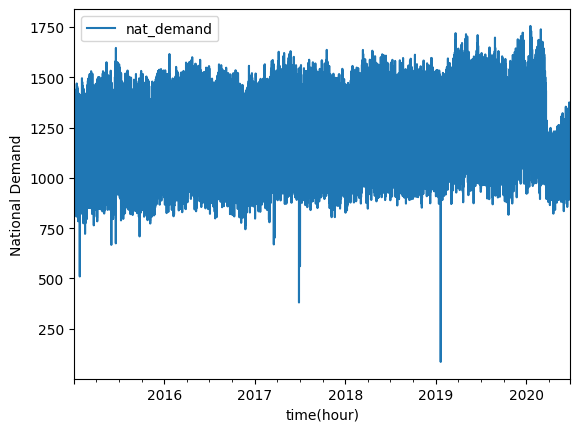

In [35]:
df[['nat_demand']]['2015-01-03': '2020-06-27'].plot()

plt.xlabel('time(hour)')
plt.ylabel('National Demand')

Let's zoom into the data and mark every Friday by vertical dotted lines.

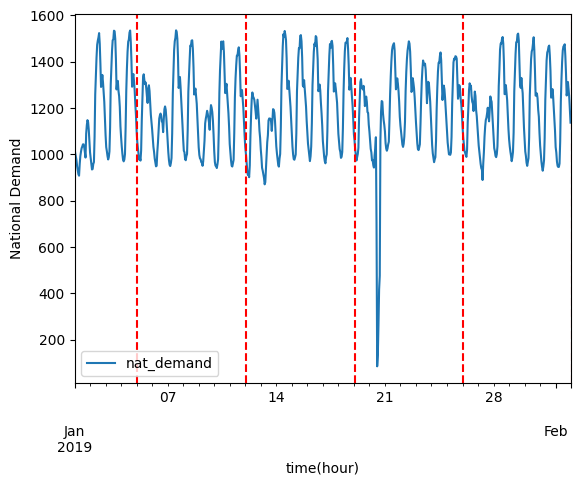

In [36]:

df[['nat_demand' ]]['2019-01-01': '2019-02-01'].plot()

plt.xlabel('time(hour)')
plt.ylabel('National Demand')

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

Seems like electricity demand decreases at the beginning of each week. Electricity demand shifts during day and night, as the electricity usage drastically changes when we compare day and night. However, the demand is unusually very low in Feb 21st. Maybe there is a mistake in the data or something happened unusual?

### Computing Autocorrelation for the 'GrossCon' Column

Text(0.5, 1.0, 'ACF Plot with Marked Peak at x=24 hours')

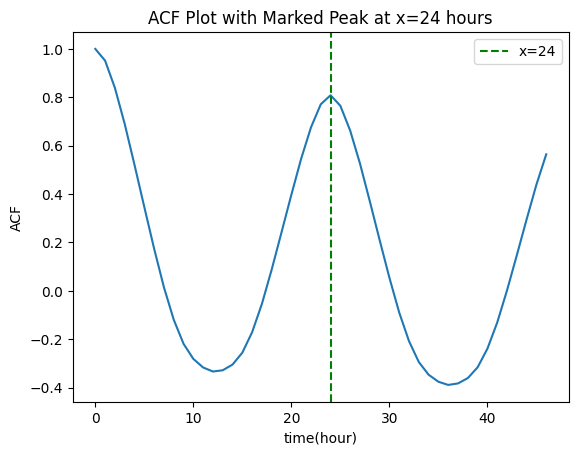

In [37]:

plt.plot(acf(df['nat_demand']))
plt.xlabel('time(hour)')
plt.ylabel('ACF')
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')

The ACF plot shows the correlation of a time series with itself at different lags.

#### Data Consistency Check:
The data exhibit seasonal variations and a periodic pattern, without any evident upward or downward trend.


## Temperature at 2 Meters:  Tocumen, Panama city, Santiago city, David city

---


The plot below displays five years' data for temperature at two meters for three different city.


Text(0, 0.5, 'Temperature at 2 Meters')

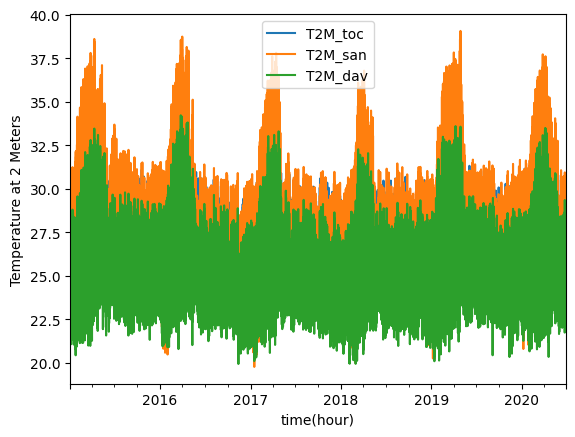

In [38]:
df[['T2M_toc', 'T2M_san', 'T2M_dav']]['2015-01-03': '2020-06-27'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Temperature at 2 Meters')

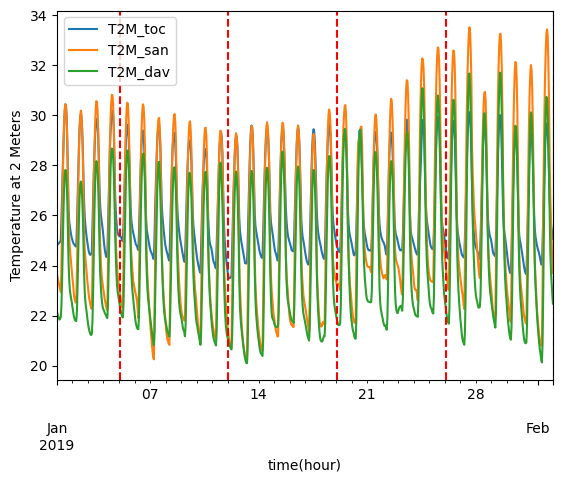

In [40]:
df[['T2M_toc', 'T2M_san', 'T2M_dav']]['2019-01-01': '2019-02-01'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Temperature at 2 Meters')
# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

Seems like Sandiago city has the highest temperature at 2 meters. Both Santiago and David city have the lowest values. Seems like Tocumen city has less variation compared to other two cities, hence it's hard to see its data because it's hidden between two other data.

### Computing Autocorrelation

Text(0.5, 1.0, 'ACF Plot with Marked Peak at x=24 hours')

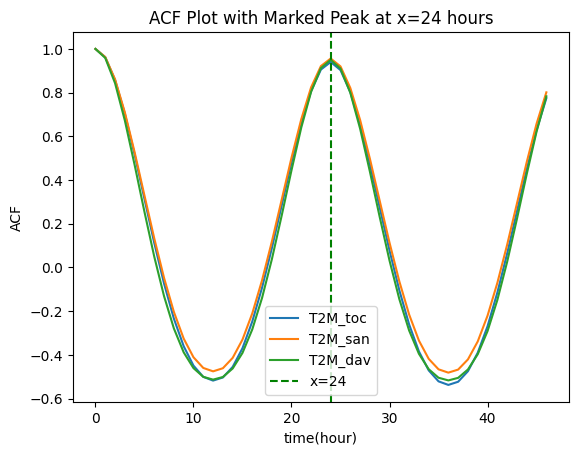

In [41]:
plt.plot(acf(df['T2M_toc']), label='T2M_toc')
plt.plot(acf(df['T2M_san']), label='T2M_san')
plt.plot(acf(df['T2M_dav']), label='T2M_dav')


plt.xlabel('time(hour)')
plt.ylabel('ACF')
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')

## Wind Speed:

Text(0, 0.5, 'Wind Speed')

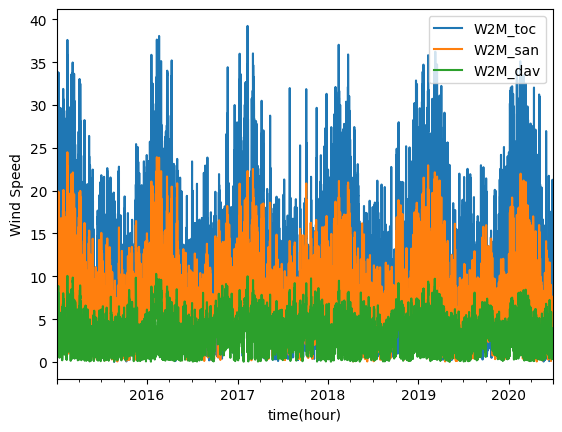

In [43]:
df[['W2M_toc', 'W2M_san','W2M_dav']]['2015-01-03': '2020-06-27'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Wind Speed')

During ferst few months, wind speed reaches its highest levels, it can be considered as normal because of winter. To observe daily trends, we will examine a month's worth of data. Seems like David city has less harsh winter conditions compared to other two cities. We can say that Tocumen city has the highest wind speed, followed by Santiago city and David city respectively.

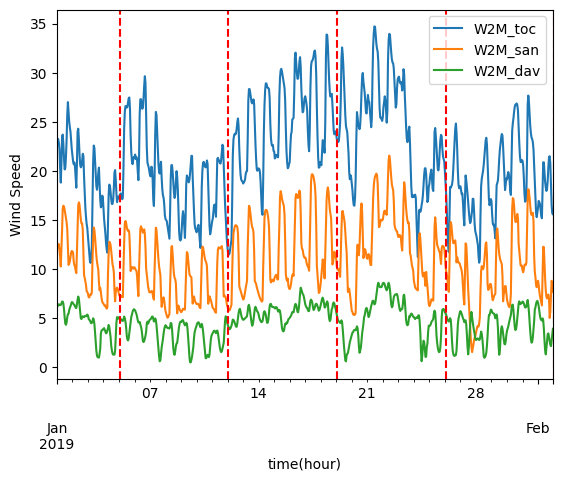

In [44]:
df[['W2M_toc', 'W2M_san','W2M_dav']]['2019-01-01': '2019-02-01'].plot()

plt.xlabel('time(hour)')
plt.ylabel('Wind Speed')
# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

Text(0.5, 1.0, 'ACF Plot with Marked Peak at x=24 hours')

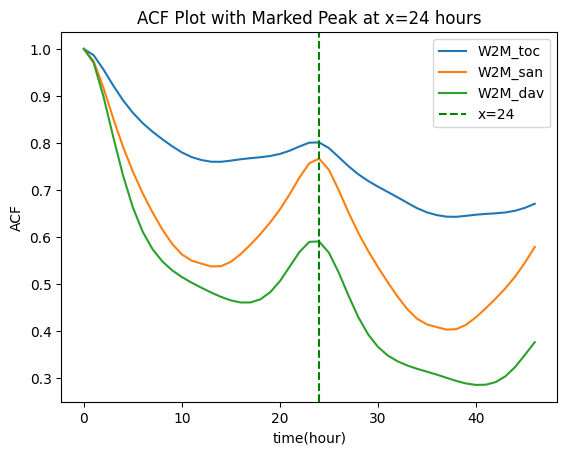

In [45]:
plt.plot(acf(df['W2M_toc']), label='W2M_toc')
plt.plot(acf(df['W2M_san']), label='W2M_san')
plt.plot(acf(df['W2M_dav']), label='W2M_dav')

plt.xlabel('time(hour)')
plt.ylabel('ACF')
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')

## Pie chart

In [46]:

def pie_chart(start, end, df):
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Aggregate the data
    aggregated_data = filtered_df.sum()
    # Convert aggregated data to absolute values
    absolute_aggregated_data = aggregated_data.abs()

    absolute_aggregated_data.drop(['nat_demand'], inplace=True)
    # Plotting the pie chart
    # absolute_aggregated_data.plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10), title='Energy Distribution for the Selected Period')

    # Explode smaller slices to make them more visible and separate labels
    explode_values = [0.1 if value < 1e6 else 0 for value in absolute_aggregated_data]

    # Plotting the adjusted pie chart
    plt.figure(figsize=(12, 12))  # Increased figure size for better clarity
    absolute_aggregated_data.plot(kind='pie', autopct='%1.1f%%',
                                  title='Energy Distribution (Excluding National Demand)',
                                  explode=explode_values)

# Filter data for a specific time period (update this to your desired dates)


### Pie Chart Year 2018

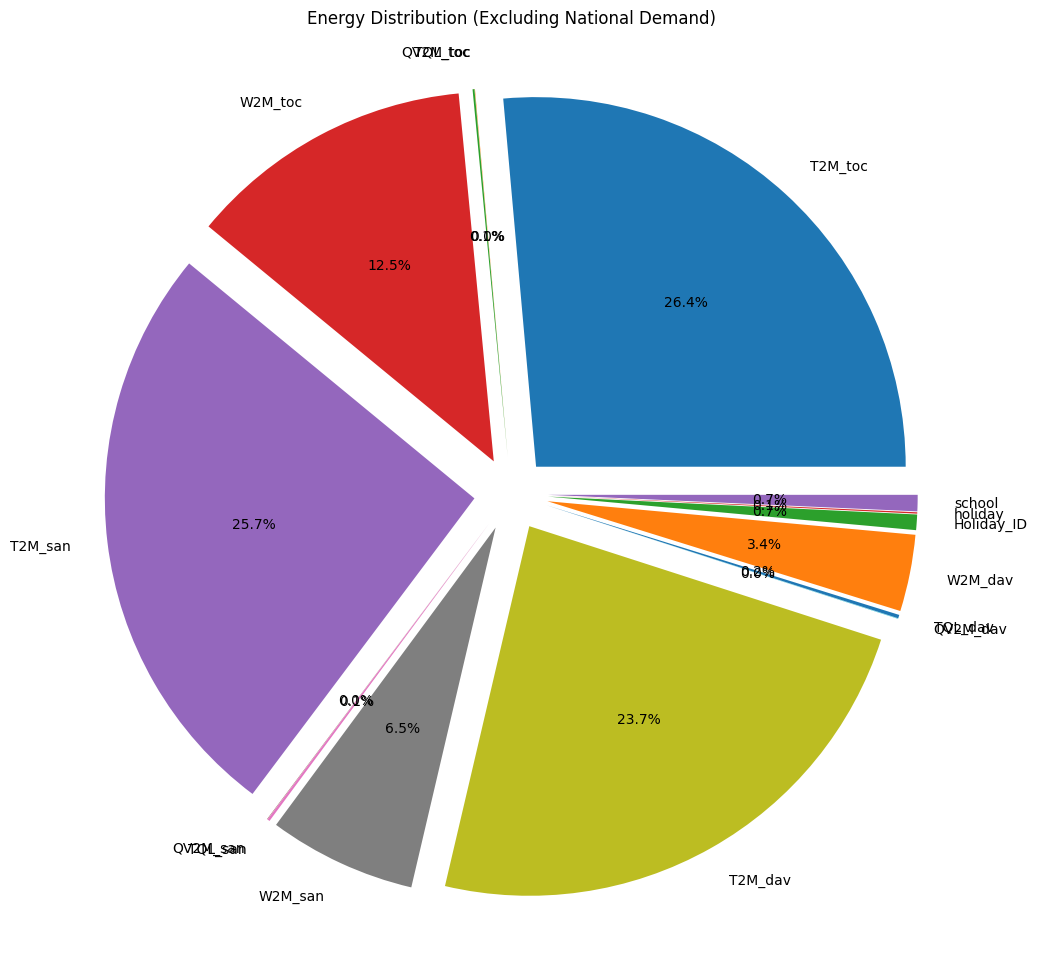

In [47]:
start_date = '2018-01-01'
end_date = '2019-01-01'
pie_chart(start_date, end_date, df)

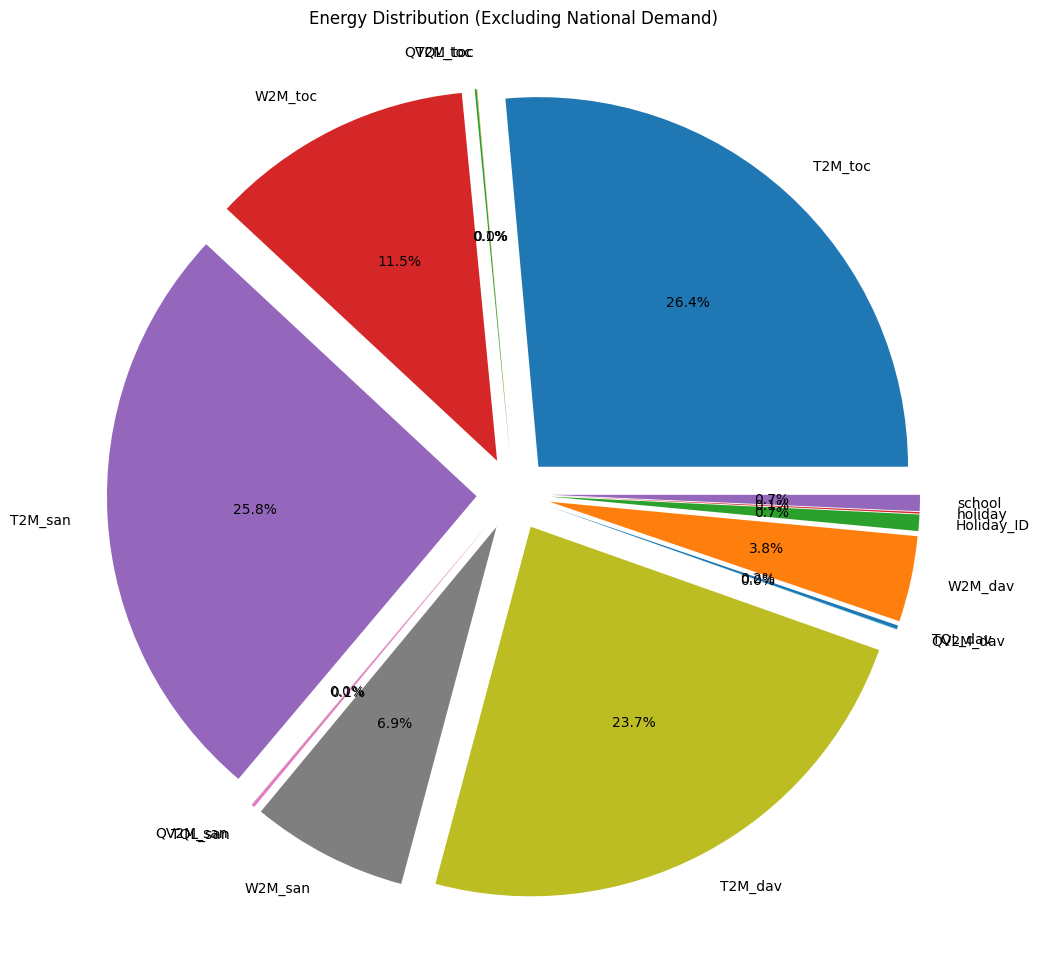

In [48]:
start_date = '2017-01-01'
end_date = '2018-01-01'
pie_chart(start_date, end_date, df)

In [49]:
def bar_chart(start_date, end_date, df):
    # Create a mask for the selected date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Aggregate the data
    aggregated_data = filtered_df.sum()
    # Convert aggregated data to absolute values
    absolute_aggregated_data = aggregated_data.abs()

    # Dropping columns 'GrossCon' and 'NetCon'
    absolute_aggregated_data.drop(['nat_demand', 'school', 'holiday', 'Holiday_ID'], inplace=True)

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    absolute_aggregated_data.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title('Energy Distribution (Excluding National Demand)')  # Add title
    plt.xlabel('Energy Types')  # Add x-label
    plt.ylabel('Energy Value')  # Add y-label
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


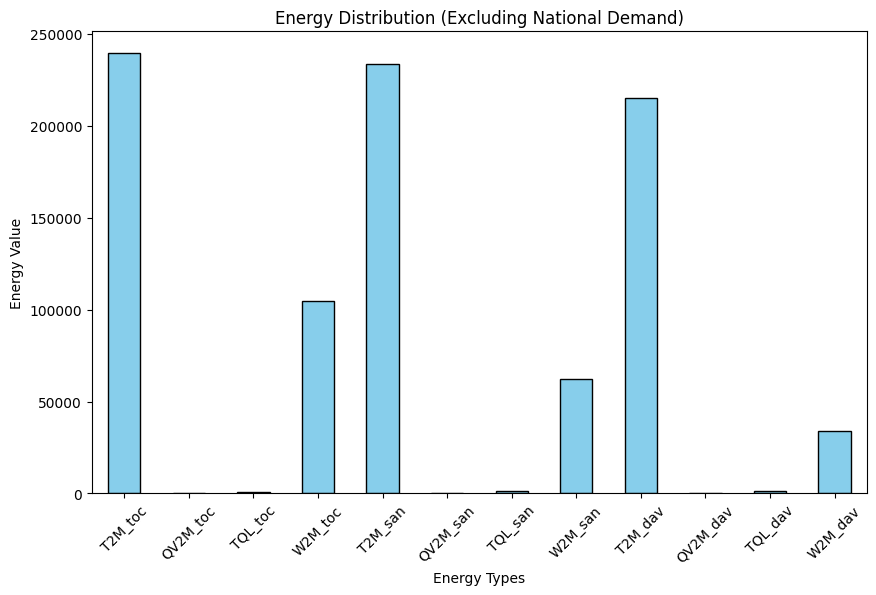

In [50]:
bar_chart(start_date, end_date, df)

 Relative humidity at 2 meters and liquid precipitation have lowest values considering their value are generally less than 0.01.

The graph presented above illustrates the contributions of various energy segments.

In [51]:


def multi_year_bar_chart(years, df):
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed

    # Adjust the width of the bars and the spacing between them
    bar_width = 0.2
    spacing = 0.05
    total_width = bar_width * len(years) + spacing * (len(years) - 1)

    # Colors for different years
    colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'purple', 'crimson', 'deepskyblue', 'gold', 'mediumorchid']


    for i, year in enumerate(years):
        # Creating a mask for each year
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        mask = (df.index >= start_date) & (df.index <= end_date)
        filtered_df = df.loc[mask]

        # Aggregate and process the data
        aggregated_data = filtered_df.sum()
        absolute_aggregated_data = aggregated_data.abs()
        absolute_aggregated_data.drop(['nat_demand', 'school', 'holiday', 'Holiday_ID'], inplace=True)

        # Calculate the offset for each bar
        offset = (np.arange(len(absolute_aggregated_data)) * total_width) + (i * bar_width)

        # Plotting the bars for each year
        plt.bar(x=offset,
                height=absolute_aggregated_data,
                width=bar_width,
                color=colors[i % len(colors)],
                edgecolor='black',
                label=f'{year}')

    # Adjust the x-ticks to be in the center of the group of bars
    plt.xticks(ticks=np.arange(len(absolute_aggregated_data)) * total_width + bar_width,
               labels=absolute_aggregated_data.index,
               rotation=45)

    plt.title('Energy Distribution by Year')
    plt.xlabel('Energy Types')
    plt.ylabel('Energy Value(GWh)')
    plt.legend(title='Year')
    plt.show()

# Sample call to the function with the DataFrame
# Replace this with your actual DataFrame
# multi_year_bar_chart([2017, 2018, 2019], df)



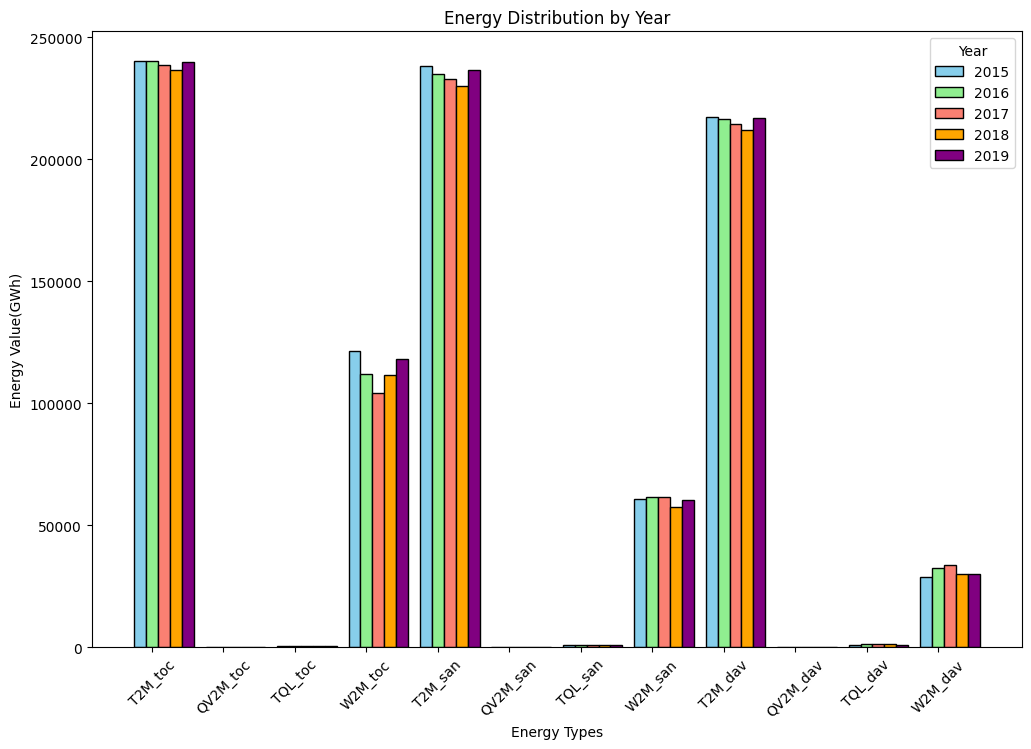

In [53]:
multi_year_bar_chart(range(2015, 2020), df)

From 2015 until 2019, the temperature at 2 meters were decreasing. Suprisingly, it increased in each 3 city in 2019. Wind speed varies each year differently in each city, hence I could not come up to a general conclusion on that matter.

Let's analyse Relative humidity at 2 meters and liquid precipitation in detail.

In [54]:
def bar_chart(start_date, end_date, df):
    # Create a mask for the selected date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Aggregate the data
    aggregated_data = filtered_df.sum()
    # Convert aggregated data to absolute values
    absolute_aggregated_data = aggregated_data.abs()

    # Dropping columns 'GrossCon' and 'NetCon'
    absolute_aggregated_data.drop(['nat_demand', 'school', 'holiday', 'Holiday_ID', 'T2M_toc', 'T2M_san', 'T2M_dav', 'W2M_toc', 'W2M_san', 'W2M_dav'], inplace=True)

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    absolute_aggregated_data.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title('Energy Distribution (Excluding National Demand)')  # Add title
    plt.xlabel('Energy Types')  # Add x-label
    plt.ylabel('Energy Value')  # Add y-label
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


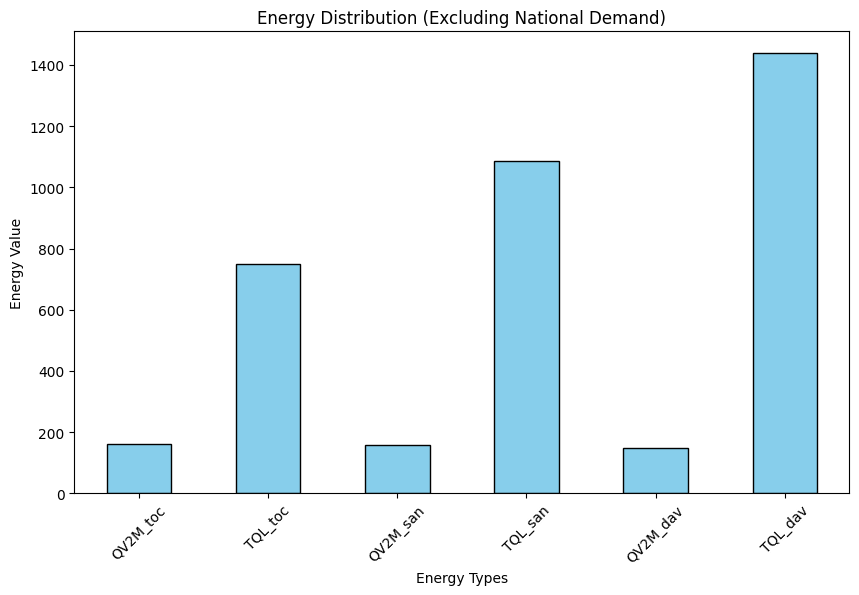

In [55]:
bar_chart(start_date, end_date, df)

In [56]:
def multi_year_bar_chart(years, df):
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed

    # Adjust the width of the bars and the spacing between them
    bar_width = 0.2
    spacing = 0.05
    total_width = bar_width * len(years) + spacing * (len(years) - 1)

    # Colors for different years
    colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'purple', 'crimson', 'deepskyblue', 'gold', 'mediumorchid']


    for i, year in enumerate(years):
        # Creating a mask for each year
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        mask = (df.index >= start_date) & (df.index <= end_date)
        filtered_df = df.loc[mask]

        # Aggregate and process the data
        aggregated_data = filtered_df.sum()
        absolute_aggregated_data = aggregated_data.abs()
        absolute_aggregated_data.drop(['nat_demand', 'school', 'holiday', 'Holiday_ID', 'T2M_toc', 'T2M_san', 'T2M_dav', 'W2M_toc', 'W2M_san', 'W2M_dav'], inplace=True)

        # Calculate the offset for each bar
        offset = (np.arange(len(absolute_aggregated_data)) * total_width) + (i * bar_width)

        # Plotting the bars for each year
        plt.bar(x=offset,
                height=absolute_aggregated_data,
                width=bar_width,
                color=colors[i % len(colors)],
                edgecolor='black',
                label=f'{year}')

    # Adjust the x-ticks to be in the center of the group of bars
    plt.xticks(ticks=np.arange(len(absolute_aggregated_data)) * total_width + bar_width,
               labels=absolute_aggregated_data.index,
               rotation=45)

    plt.title('Energy Distribution by Year')
    plt.xlabel('Energy Types')
    plt.ylabel('Energy Value(GWh)')
    plt.legend(title='Year')
    plt.show()

# Sample call to the function with the DataFrame
# Replace this with your actual DataFrame
# multi_year_bar_chart([2017, 2018, 2019], df)



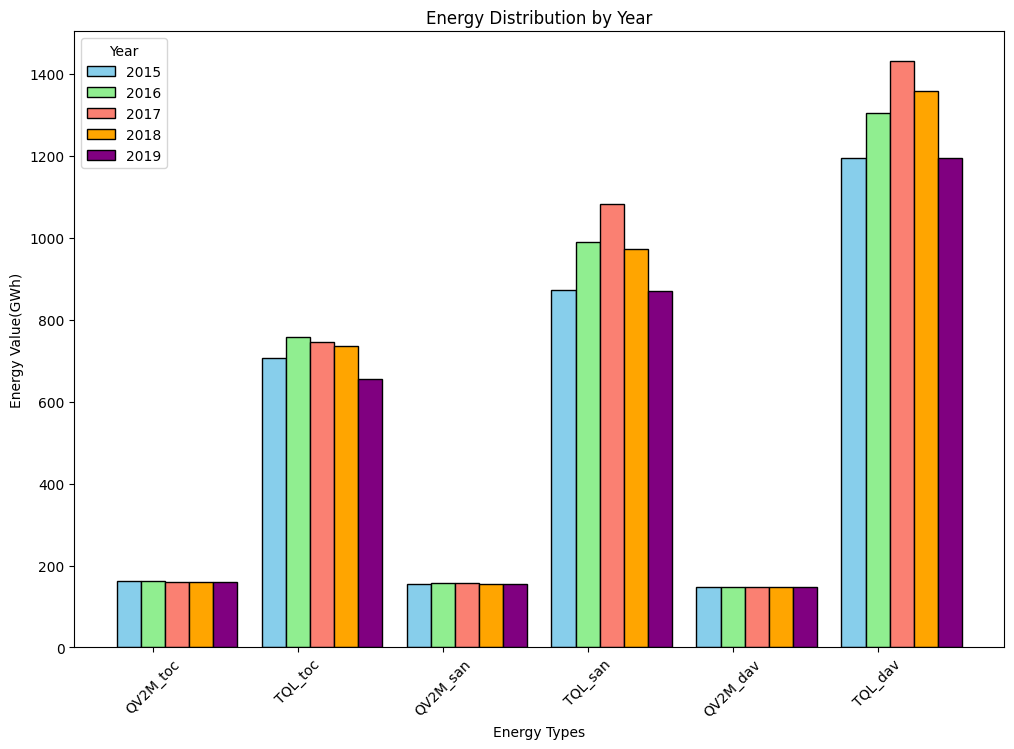

In [57]:
multi_year_bar_chart(range(2015, 2020), df)

Seems like relative humidity at 2 meters is relatively constant each year. However, liquid precipitation seems to be increased until 2017 and decresed after that year.

# Modeling:
### Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller (ADF) test is a statistical test used in time series analysis to determine whether a given time series is stationary or non-stationary. Stationarity is a crucial assumption for many time series modeling techniques.

The code below defines a function `adf_test(series, title='')` that performs the ADF test on a time series and provides a comprehensive report. The function takes the following parameters:

- `series`: The time series to be tested.
- `title` (optional): An optional title to label the ADF test.

The ADF test report includes the ADF test statistic, p-value, the number of lags used in the test, and the number of observations. Additionally, it compares the test statistic to critical values at various significance levels.

The test results are interpreted as follows:
- If the p-value is less than or equal to 0.05, there is strong evidence against the null hypothesis, indicating that the data is stationary, and the null hypothesis is rejected.
- If the p-value is greater than 0.05, there is weak evidence against the null hypothesis, suggesting that the data is non-stationary, and the null hypothesis is not rejected.

This ADF test function is a valuable tool for assessing the stationarity of time series data, a fundamental step in time series analysis and modeling.


In [58]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [60]:
adf_test(df['nat_demand'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -20.961750
p-value                     0.000000
# lags used                57.000000
# observations          47990.000000
critical value (1%)        -3.430486
critical value (5%)        -2.861600
critical value (10%)       -2.566802
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


**Augmented Dickey-Fuller Test Results**

The Augmented Dickey-Fuller (ADF) test was conducted on the given time series data with the following outcomes:

- **ADF test statistic:** The ADF test statistic value is -20.961750.

- **p-value:** The p-value obtained from the test is 0.000000.

- **Number of lags used:** In the test, 57 lags were utilized.

- **Number of observations:** The total number of observations in the dataset is 47,990.



Based on these test results, the following conclusions can be drawn:

- There is strong evidence against the null hypothesis.

- The null hypothesis is rejected.

- The data exhibits no unit root and is considered stationary.

These findings suggest that the time series data under examination is stationary and does not possess a unit root, which is a crucial characteristic for various time series analysis and modeling techniques.



### Data Splitting into Training and Testing Sets
To prepare our data for modeling and evaluation, we need to split it into training and testing sets. This allows us to train our model on one portion of the data and assess its performance on another. Below is the code to obtain information about the maximum and minimum timestamps in our dataset:

In [61]:
# Printing the maximum timestamp in the dataset
print(df.index.max())

# Printing the minimum timestamp in the dataset
print(df.index.min())


2020-06-27 00:00:00
2015-01-03 01:00:00


Selecting the following date as the dividing point between training and testing data:

In [63]:
dev_date_str = '2017-12-31'
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
dev_date = pd.Timestamp(dev_date, tz='UTC')

# Convert the index of df to UTC if it's not already timezone-aware
df.index = df.index.tz_localize('UTC')

train_data = df[:dev_date]
test_data = df[dev_date:]

## First Model: Exponential Smoothing
### Model Evaluation: Performance Assessment on Test Set

This section focuses on evaluating the model's performance by comparing its predictions against the actual values in the test set. It involves a thorough analysis of how accurately the model has forecasted, using various metrics to assess its effectiveness and reliability when applied to unseen data.

In [64]:
fitted_model = ExponentialSmoothing(train_data['nat_demand'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Model Evaluation on Test Dataset

In this section, we assess the model's predictive accuracy using the test dataset. The process involves:

1. **Prediction Setup**:
   - Duration for prediction: 120 days, equivalent to `120 * 24` hours.
   - Calculation of `end_date` by adding the number of hours to `dev_date`.

2. **Extracting Test Data**:
   - Retrieval of Gross Consumption (`'GrossCon'`) data from `dev_date` to `end_date`.

3. **Generating Forecasts**:
   - The model forecasts for the defined period (`number_of_hours_to_predict`) are produced and labeled as 'HW_Forecast'.

4. **Comparing Predictions with Actuals**:
   - The model's forecasts are compared against the actual values in the test data to evaluate accuracy.

This evaluation is crucial to understand the model's effectiveness and reliability in forecasting over the specified time frame.

In [65]:
# Set the number of days for which the prediction is to be made
number_of_days = 120

# Calculate the total number of hours to predict based on the number of days
number_of_hours_to_predict = number_of_days * 24

# Calculate the end date for the prediction by adding the total hours to the development date (dev_date)
end_date = dev_date + timedelta(hours=number_of_hours_to_predict - 1)

# Extract the actual Gross Consumption data from the test dataset for the specified period
y = test_data['nat_demand'][dev_date:end_date]

# Use the fitted model to forecast the values for the specified number of hours and rename the output series to 'HW_Forecast'
test_predictions = fitted_model.forecast(number_of_hours_to_predict).rename('HW_Forecast')


### Visual Comparison of Train, Test, and Predicted Values
The following code snippet is designed to visually compare the Gross Consumption values across the training data, test data, and the model's predictions:

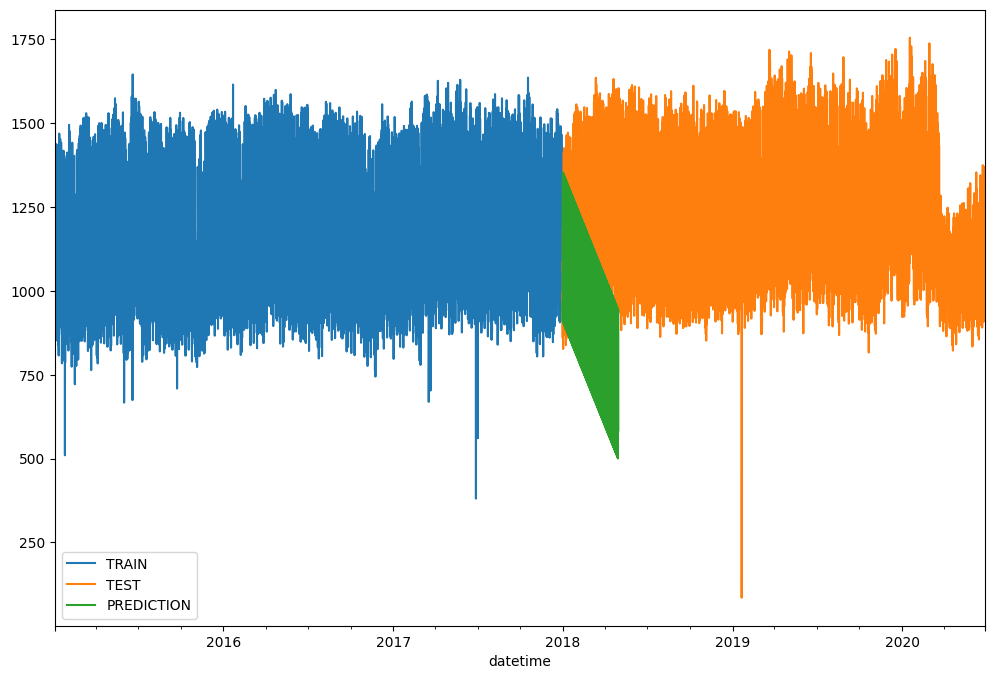

In [66]:
# Plotting the Gross Consumption from the training data
train_data['nat_demand'].plot(legend=True, label='TRAIN')

# Plotting the Gross Consumption from the test data
test_data['nat_demand'].plot(legend=True, label='TEST', figsize=(12,8))

# Plotting the predicted Gross Consumption values
test_predictions.plot(legend=True, label='PREDICTION');


To get a clearer comparison, let's zoom in on the plot:

<Axes: xlabel='datetime'>

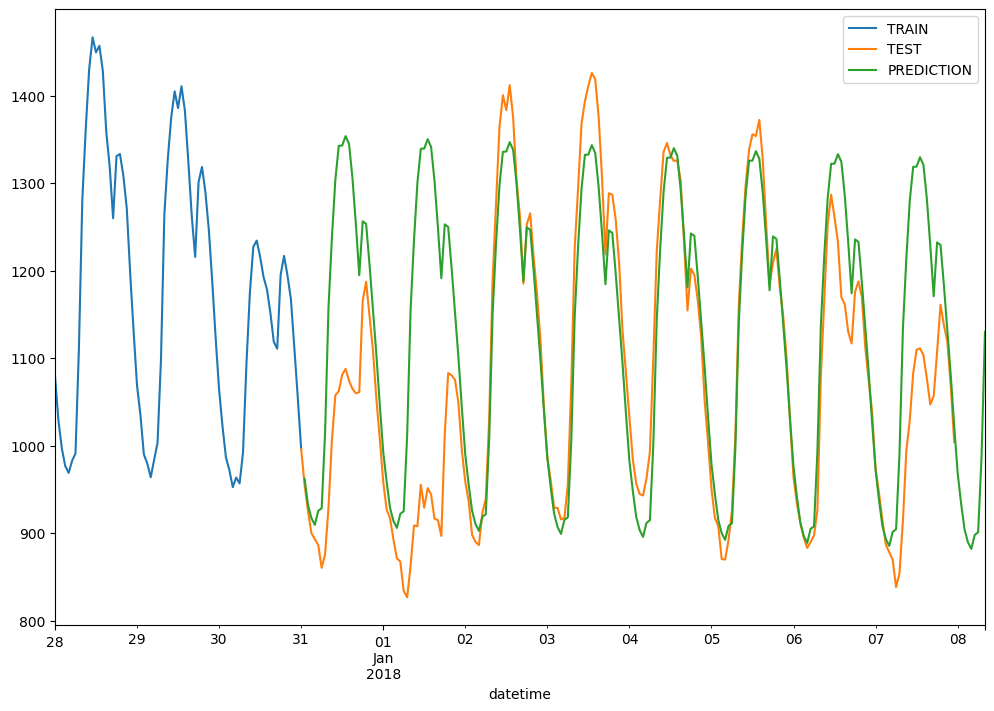

In [67]:
# Plotting the training data
train_data['nat_demand']['2017-12-28':].plot(legend=True, label='TRAIN')

# Plotting the testing data
test_data['nat_demand'][:'2018-01-07'].plot(legend=True, label='TEST', figsize=(12, 8))

# Plotting the predictions (first 200 points)
test_predictions[:200].plot(legend=True, label='PREDICTION')


The results are unsatisfactory because the predicted values show a downward trend and do not closely resemble the test dataset for longer time periods. Let's assess the results quantitatively.

### Evaluation Metrics
In this section, we will calculate and present various evaluation metrics to assess the performance of our model. We are using the scikit-learn library to compute the following metrics:

#### Mean Absolute Error (MAE):

MAE measures the average absolute difference between the actual values (y) and the predicted values (test_predictions). It provides a measure of the model's accuracy in predicting the target variable.

In [68]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y, test_predictions)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 275.19812854618755


Mean Absolute Error is 275.19812854618755.

#### Mean Squared Error (MSE):

MSE calculates the average of the squared differences between the actual values and the predicted values. It penalizes larger errors more heavily than MAE.

In [69]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, test_predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 102430.67639839271


Mean Squared Error is 102430.67639839271. MSE is higher than MAE.

#### Root Mean Squared Error (RMSE):

RMSE is the square root of MSE and provides a measure of the model's error in the same units as the target variable (y).

In [70]:
import numpy as np
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 320.0479282832381


These errors being significant signify that the model is performing poorly. It implies that the model's predictions are not accurately capturing the underlying patterns in the data, and there is room for improvement in the model's predictive capabilities. Further analysis and potentially model refinement may be needed to enhance its performance.

## Forecasting into the Future
### Exponential Smoothing
Although this model exhibited a notably high error, let's assess how it performs in predicting future values.

In [71]:
final_model = ExponentialSmoothing(df['nat_demand'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='datetime'>

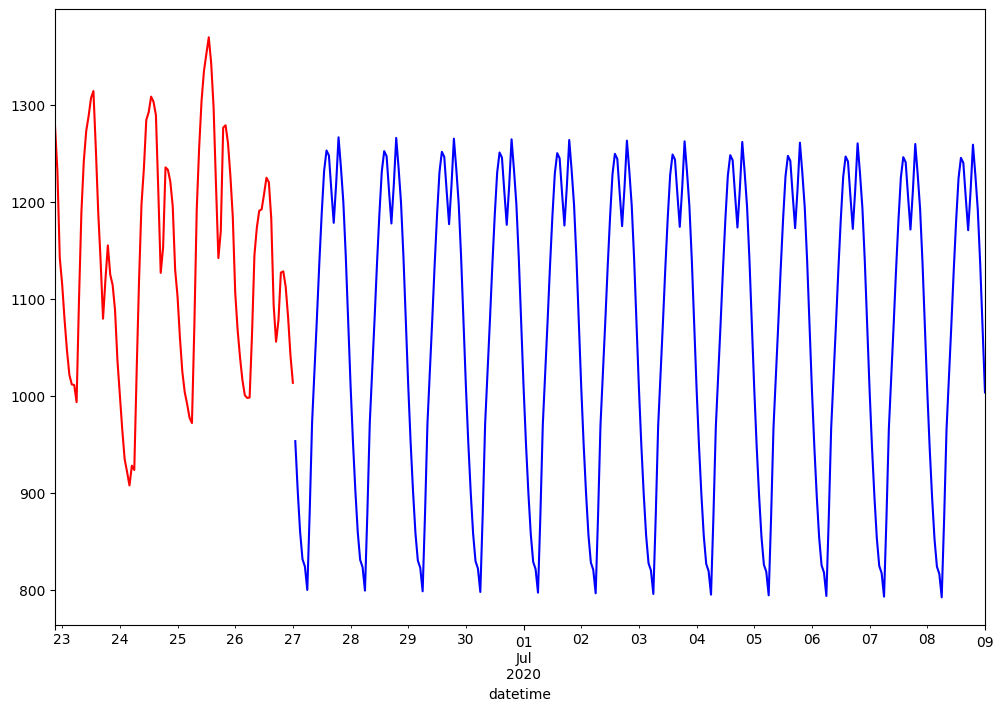

In [72]:
# Setting the number of days for the forecast
day_forecast = 12
hours_forecast = day_forecast * 24

# Generating forecast predictions
forecast_predictions = final_model.forecast(hours_forecast)

# Plotting the last 100 data points in red and the forecast in blue
df['nat_demand'][-100:].plot(figsize=(12, 8), color='red')
forecast_predictions.plot(color='blue')

As anticipated, this model performs inadequately, and the disparity between the actual data and the predicted data is readily apparent upon visual inspection.

## Autoregression (AR) Model

The Autoregression (AR) model is a fundamental time series forecasting technique that is particularly useful when dealing with data exhibiting temporal dependencies. It assumes that future values in a time series can be predicted based on their historical values.

### Key Concepts:

- **Time Dependency:** The AR model captures the idea that each data point in a time series is influenced by its previous observations.

- **Lag Order (p):** The choice of the lag order, denoted as 'p', determines how many past time steps are considered for predicting the future value.

- **Coefficients:** The model estimates coefficients for each lagged value, which govern the strength and direction of the relationship between past observations and the current one.

- **Forecasting:** Once trained, the AR model can make future predictions by applying the learned coefficients to the historical data.

- **Model Evaluation:** Performance evaluation is done using metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

- **Limitations:** The AR model assumes linear relationships and may not perform well in complex, nonlinear scenarios.

To use the AR model effectively, you'll need to select an appropriate lag order 'p' and evaluate its performance on your specific time series data. Model selection techniques like AIC and BIC can help with lag order selection.


In [73]:
# Importing the Autoregression model from statsmodels library
from statsmodels.tsa.ar_model import AutoReg,ARResults

In [74]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [75]:
model = AutoReg(train_data['nat_demand'], lags=1)

In [76]:
ARfit = model.fit()

In [77]:
ARfit.params

,0
const,58.996727
nat_demand.L1,0.949018


In [78]:
# This is the general format for obtaining predictions
start=len(train_data['nat_demand'])
end=len(train_data['nat_demand'])+len(test_data['nat_demand'])-1
predictions1 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

<Axes: xlabel='datetime'>

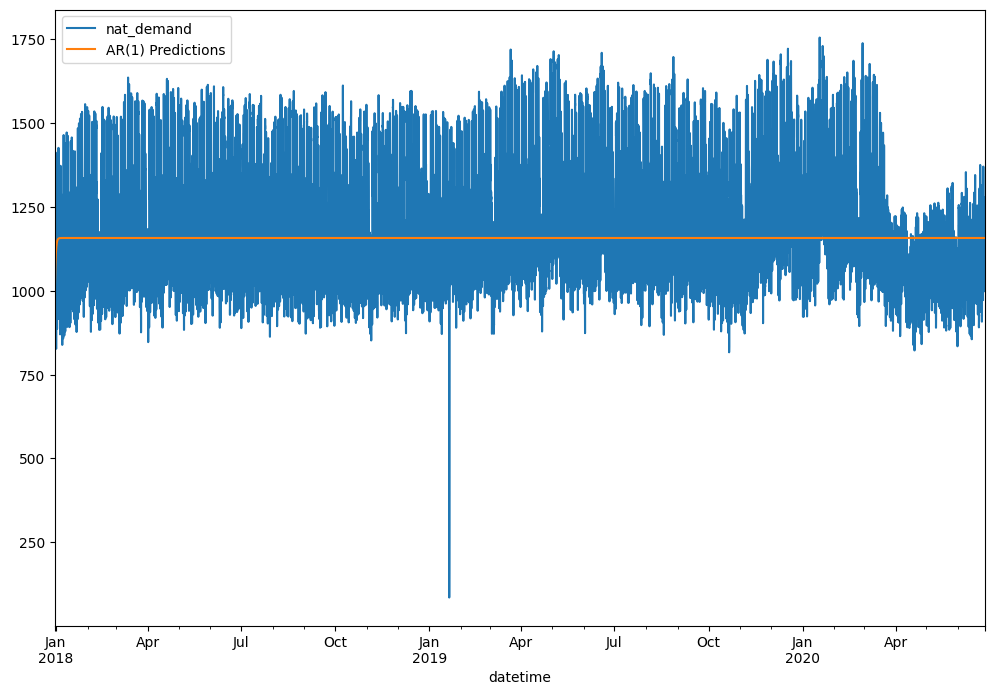

In [79]:
test_data['nat_demand'].plot(figsize=(12, 8), legend=True)
predictions1.plot(figsize=(12, 8), legend=True)

In [80]:

mae = mean_absolute_error(test_data['nat_demand'], predictions1)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 159.92319572435946


In [81]:
mse = mean_squared_error(test_data['nat_demand'], predictions1)
print("Mean Squared Error:", mse)


Mean Squared Error: 38211.64142725228


In [82]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 195.47798195001982


The outcome of this particular model appears to be a flat horizontal line, which indicates that it struggles to capture the fluctuations present in the target variable. Furthermore, the Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) all exhibit substantial values, underscoring the model's inadequacy in accurately predicting the target variable. These results collectively suggest that the model's performance is subpar and may require further refinement or the exploration of alternative modeling techniques to better capture the underlying patterns in the data.

## Automated ARIMA Model Selection with `pmdarima`

In time series analysis and forecasting, selecting the appropriate ARIMA model parameters can be a challenging task. The `pmdarima` library provides a convenient and automated way to perform ARIMA model selection.

The code snippet below demonstrates the use of the `auto_arima` function from `pmdarima`. This function automates the process of determining the optimal ARIMA model parameters based on the provided time series data.



In [83]:
# Importing the `auto_arima` function from `pmdarima` library
!pip install pmdarima
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.5 MB/s eta 0:00:00


# Automated ARIMA Model Selection and Summary

In time series analysis, selecting the optimal ARIMA model parameters can be a crucial step in achieving accurate forecasts. The code snippet below demonstrates the use of the `auto_arima` function to automate the process of finding the best ARIMA model for a given time series.

In [84]:
# Using auto_arima to automatically select the best ARIMA model for 'GrossCon' time series data

# Data input: 'GrossCon' time series data (first 1000 data points)
stepwise_fit = auto_arima(df['nat_demand'][:500],

                          # Starting values for ARIMA orders
                          start_p=0,  # Autoregressive order (p)
                          start_q=0,  # Moving average order (q)

                          # Maximum allowable ARIMA orders
                          max_p=3,  # Maximum autoregressive order (p)
                          max_q=3,  # Maximum moving average order (q)

                          # Seasonality information (24-hour seasonality)
                          m=24,  # Number of time steps in a seasonal cycle

                          # Enable seasonal decomposition
                          seasonal=True,

                          # Differencing order (None implies automatic differencing)
                          d=None,

                          # Display progress information during model search
                          trace=True,

                          # Behavior when an order doesn't work (ignore errors)
                          error_action='ignore',

                          # Suppress convergence warnings
                          suppress_warnings=True,

                          # Use the stepwise search approach for efficiency
                          stepwise=True)


stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=6372.507, Time=9.91 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=6621.700, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=15.56 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=5797.247, Time=6.09 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=8434.955, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=6005.168, Time=0.74 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=5797.931, Time=6.99 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=5675.693, Time=9.44 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=5677.804, Time=12.43 sec
 ARIMA(0,0,0)(0,0,2)[24] intercept   : AIC=6242.280, Time=3.41 sec
 ARIMA(1,0,1)(0,0,2)[24] intercept   : AIC=4911.568, Time=8.85 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=5009.431, Time=3.07 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept   : AIC=4705.220, Time=11.20 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=4688.730, Time=4.16 sec
 ARIMA(1,0,1)(1,0,0)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  500
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood               -2338.365
Date:                            Wed, 31 Jul 2024   AIC                           4688.730
Time:                                    16:18:06   BIC                           4714.018
Sample:                                01-03-2015   HQIC                          4698.653
                                     - 01-23-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6456      0.908      1.813      0.070      -0.133       3.425
ar.L1          0.9362      0.016     58.289      0.000       0.905       0.968
ma.L1          0.4379      0.037     11.828      0.000       0.365       0.511
ar.S.L24       0.9750      0.009    108.215      0.000       0.957       0.993
ma.S.L24      -0.7303      0.043    -17.084      0.000      -0.814      -0.647
sigma2       708.9631     39.821     17.804      0.000     630.916     787.010
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                96.25
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                             0.15
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA(1,0,1)(1,0,1)[24] is the best model.

In [86]:
# Import the necessary library
import statsmodels.api as sm

# Create the ARIMA model with the selected parameters
model = sm.tsa.ARIMA(train_data['nat_demand'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 24), enforce_stationarity=False)

# Fit the ARIMA model to the data
model_fit = model.fit()




In [87]:
your_desired_number_of_steps = 24 * 30

# Make future predictions
forecasted_values = model_fit.forecast(steps=your_desired_number_of_steps)

<Axes: xlabel='datetime'>

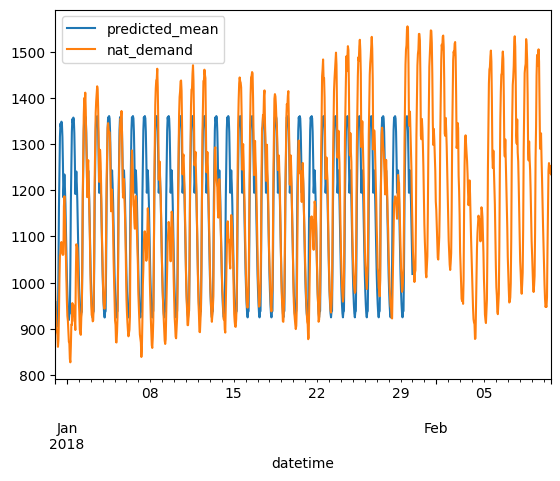

In [88]:
forecasted_values.plot(legend=True)
test_data['nat_demand'][:1000].plot(legend=True)

In [89]:
mae = mean_absolute_error(test_data['nat_demand'][:your_desired_number_of_steps], forecasted_values)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 85.31908876958254


In [90]:
mse = mean_squared_error(test_data['nat_demand'][:your_desired_number_of_steps], forecasted_values)
print("Mean Squared Error:", mse)

Mean Squared Error: 13866.54597199686


In [91]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 117.75629907566244


The results suggest that this model exhibits a lower level of error, indicating its adequacy as an effective predictive model.

## Seasonal Autoregressive Integrated Moving Average (SARIMA) Model

The Seasonal Autoregressive Integrated Moving Average, abbreviated as SARIMA, is an advanced time series forecasting model that extends the capabilities of the ARIMA (Autoregressive Integrated Moving Average) model. SARIMA is specifically designed to handle time series data with recurring seasonal patterns.

### Key Characteristics:

- **Autoregressive (AR) Component:** SARIMA includes an autoregressive component, similar to ARIMA, to capture the relationship between the current value and its past values.

- **Differencing (I):** Like ARIMA, SARIMA may require differencing to make the time series stationary by removing trends and seasonality.

- **Moving Average (MA) Component:** SARIMA incorporates a moving average component to account for the influence of past errors or residuals on the current value.

- **Seasonal Component (S):** What distinguishes SARIMA is its inclusion of seasonal components. These components capture patterns that repeat at regular intervals, making SARIMA suitable for data with strong seasonal trends.

- **Seasonal Differencing (D):** SARIMA allows for seasonal differencing to address seasonal patterns within the data.

- **Model Selection:** Selecting the appropriate SARIMA model involves determining the orders for the AR, I, MA, and seasonal components. This process often requires data analysis and may involve techniques like ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function) plots.

- **Forecasting:** Once trained, the SARIMA model can provide future predictions, including point forecasts and prediction intervals.

SARIMA models are valuable tools for handling time series data with complex seasonality, offering accurate forecasts for applications such as sales forecasting, demand prediction, and financial time series analysis. However, effective utilization of SARIMA requires a strong grasp of time series concepts and careful model selection.


### Using the seasonal decomposed data as exogenic parameter in SARIMA.

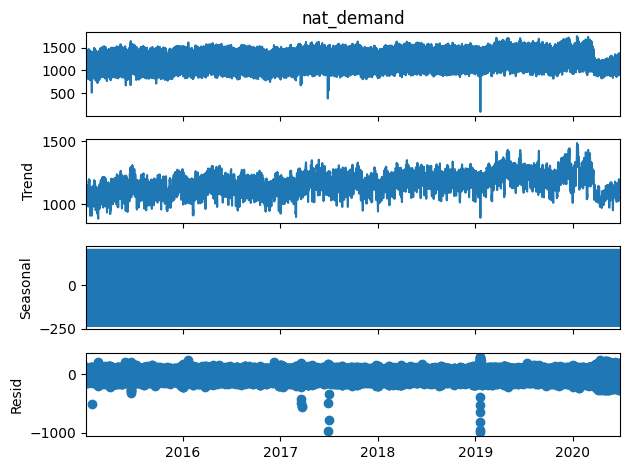

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['nat_demand'], model='additive')  # model='add' also works
result.plot();

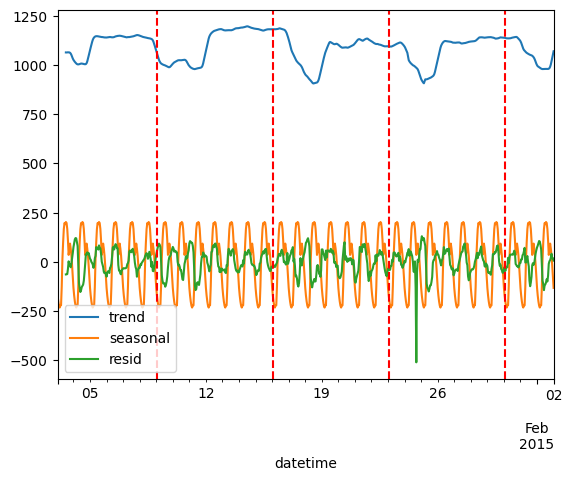

In [93]:
n_days = 30
n = 24 * n_days
# To plot the first n points of the trend component
result.trend[:n].plot(legend=True);

# To plot the first n points of the seasonal component
result.seasonal[:n].plot(legend=True);

# To plot the first n points of the residual component
result.resid[:n].plot(legend=True);

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 4:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

<Axes: xlabel='datetime'>

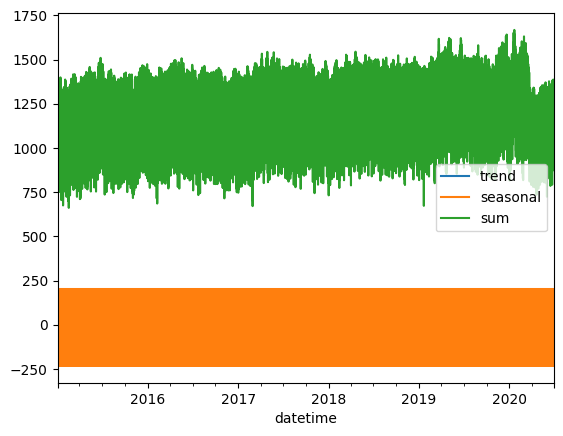

In [94]:
decomp_data = {}
decomp_data['trend'] = result.trend
decomp_data['seasonal'] = result.seasonal
df_decom_data = pd.DataFrame(decomp_data)
df_decom_data['sum'] = df_decom_data['trend'] + df_decom_data['seasonal']
df_decom_data.plot()

In [95]:
df_decom_data.head()

,trend,seasonal,sum
datetime,,,
2015-01-03 01:00:00+00:00,NaN,-171.887459,NaN
2015-01-03 02:00:00+00:00,NaN,-201.678198,NaN
2015-01-03 03:00:00+00:00,NaN,-223.106475,NaN
2015-01-03 04:00:00+00:00,NaN,-232.980741,NaN
2015-01-03 05:00:00+00:00,NaN,-220.058009,NaN


Creating train and test data sets:

In [96]:
dev_date_str = '2017-12-31'
# Convert dev_date_str to a datetime object
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
dev_date = pd.Timestamp(dev_date, tz='UTC')
train_data_exo = df[:dev_date]
test_data_exo = df[dev_date:]

df_decom_data_train = df_decom_data[:dev_date]

<Axes: xlabel='datetime'>

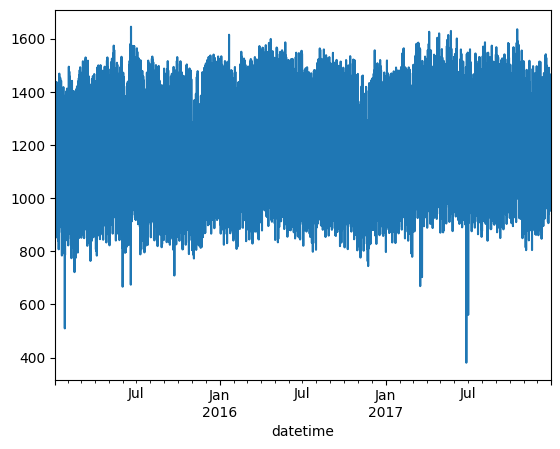

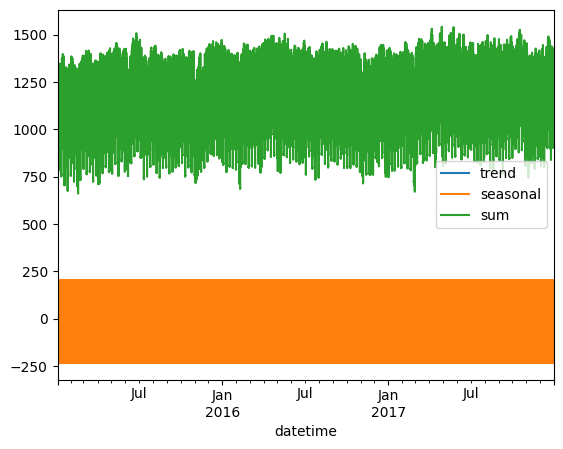

In [97]:
ind = 100000

train_data_exo['nat_demand'][:ind].plot()
df_decom_data_train[:ind].plot()

Fitting the model to the train data set:

In [100]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

index = - 200

model = SARIMAX(train_data_exo['nat_demand'][index:],
                exog=df_decom_data_train[index:],
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 24),
                enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         nat_demand   No. Observations:                  200
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood                -901.774
Date:                            Wed, 31 Jul 2024   AIC                           1819.548
Time:                                    16:26:40   BIC                           1845.934
Sample:                                12-22-2017   HQIC                          1830.226
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.3813      0.028     13.511      0.000       0.326       0.437
seasonal       0.2412      0.037      6.452      0.000       0.168       0.315
sum            0.6226      0.014     44.195      0.000       0.595       0.650
ar.L1          0.8697      0.042     20.907      0.000       0.788       0.951
ma.L1          0.2899      0.066      4.396      0.000       0.161       0.419
ar.S.L24       0.3535      0.166      2.128      0.033       0.028       0.679
ma.S.L24       0.0585      0.193      0.303      0.762      -0.320       0.437
sigma2       468.0636     38.367     12.200      0.000     392.867     543.261
===================================================================================
Ljung-Box (L1) (Q):                   1.26   Jarque-Bera (JB):                15.73
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.18
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.29e+18. Standard errors may be unstable.
"""

Preparing the exog_forcast data for prediction purposes:

In [112]:
# Debug: Check the shape of exog_forecast
print(f"Shape of exog_forecast: {exog_forecast.shape}")
print(f"Expected shape: ({n_hours_to_predict}, {df_decom_data_train.shape[1]})")

# Ensure the length of exog_forecast matches n_hours_to_predict
if exog_forecast.shape[0] != n_hours_to_predict:
    print(f"Warning: Length of exog_forecast does not match the number of periods to forecast.")
else:
    print("Shape of exog_forecast is correct.")

# Adjust exog_forecast if necessary
if exog_forecast.shape[0] != n_hours_to_predict:
    exog_forecast = exog_forecast.head(n_hours_to_predict)

Shape of exog_forecast: (21744, 3)
Expected shape: (21817, 3)


In [117]:
# Recalculate the forecast period to match the available exogenous data
forecast_period_length = exog_forecast.shape[0]

# Adjust the end_hour based on the length of exog_forecast
new_end_hour = start_hour + pd.Timedelta(hours=forecast_period_length)

# Adjust the forecast period delta
delt = new_end_hour - start_hour

# Extract the exogenous forecast data
start_hour_exo_test = start_hour - pd.DateOffset(years=n_years_back)
exog_forecast = df_decom_data_train[start_hour_exo_test: start_hour_exo_test + delt]

# Ensure that the length matches
print(f"Adjusted shape of exog_forecast: {exog_forecast.shape}")


Adjusted shape of exog_forecast: (21672, 3)


In [124]:
exog_forecast = exog_forecast.fillna(method='ffill')  # Forward fill


# Use the available length of exog_forecast
forecast_end_hour = start_hour + pd.Timedelta(hours=exog_forecast.shape[0])

# Predict using the adjusted end hour
predictions = results.predict(start=start_hour,
                              end=forecast_end_hour,
                              exog=exog_forecast).rename('SARIMAX(1, 0, 1)(1, 0, 1, 24) Predictions')

print(predictions)


2017-12-31 00:00:00+00:00     996.614321
2017-12-31 01:00:00+00:00       8.619938
2017-12-31 02:00:00+00:00      -4.549043
2017-12-31 03:00:00+00:00     -10.235863
2017-12-31 04:00:00+00:00     -18.853227
                                ...     
2020-06-20 20:00:00+00:00    1260.793661
2020-06-20 21:00:00+00:00    1225.095087
2020-06-20 22:00:00+00:00    1176.949480
2020-06-20 23:00:00+00:00    1121.896053
2020-06-21 00:00:00+00:00    1070.995809
Freq: H, Name: SARIMAX(1, 0, 1)(1, 0, 1, 24) Predictions, Length: 21673, dtype: float64


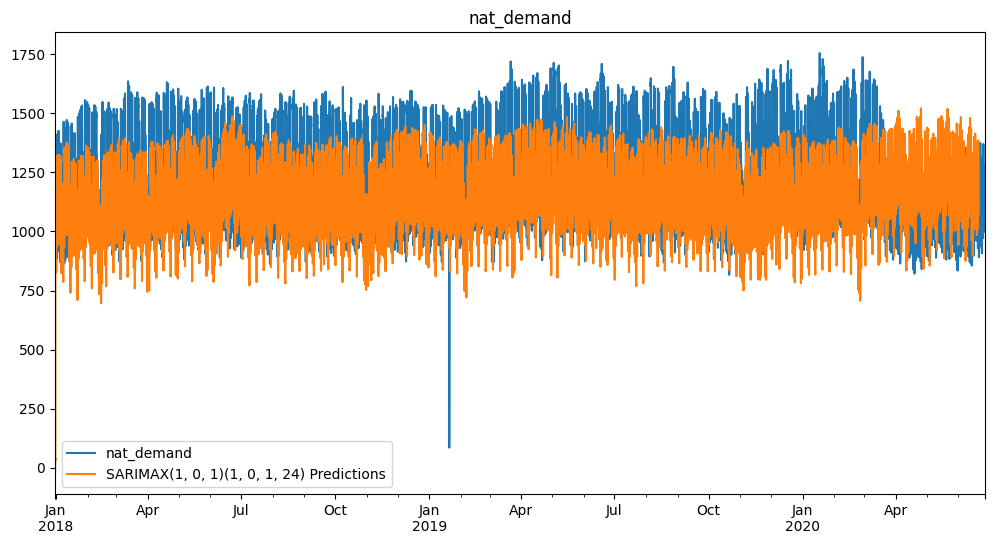

In [126]:
# Plot predictions against known values
title = 'nat_demand'
ylabel=''
xlabel=''

ax = test_data_exo['nat_demand'][:100000].plot(legend=True,figsize=(12,6),title=title)
predictions[:100000].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

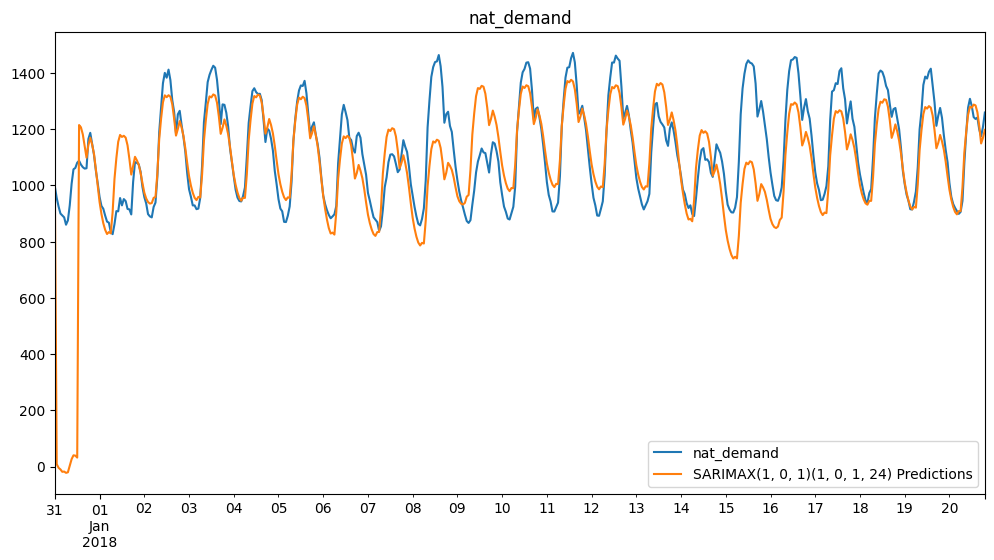

In [127]:
ax = test_data_exo['nat_demand'][:500].plot(legend=True,figsize=(12,6),title=title)

predictions[:500].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [130]:
# Trim test_data_exo['nat_demand'] to match the length of predictions
trimmed_demand = test_data_exo['nat_demand'].iloc[:len(predictions[:-1])]
# Ensure both arrays are of the same length
trimmed_demand = test_data_exo['nat_demand'].iloc[:len(predictions[:-1])]

# Calculate MAE
mae = mean_absolute_error(trimmed_demand, predictions[:-1])
print("Mean Absolute Error:", mae)


Mean Absolute Error: 117.40205312501112


In [132]:
# Trim test_data_exo['nat_demand'] to match the length of predictions
trimmed_demand = test_data_exo['nat_demand'].iloc[:len(predictions[:-1])]
# Ensure both arrays are of the same length
trimmed_demand = test_data_exo['nat_demand'].iloc[:len(predictions[:-1])]

# Calculate MAE
mse =  mean_squared_error(trimmed_demand, predictions[:-1])
print("Mean Absolute Error:", mse)

Mean Absolute Error: 23497.466707075808


In [133]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
df.shape

Root Mean Squared Error: 153.28883425440944


(48048, 16)

### Apply on the above method on all of the data:

In [191]:
# Example of correct slicing indices
ind_start = 48000  # Example valid starting index within the dataset range
ind_end = 48016    # Example valid ending index within the dataset range

# Ensure both slices are non-empty and have the same length
print("Data before slicing:")
print(df['nat_demand'][ind_start:ind_end])
print(df_decom_data[ind_start:ind_end])

print("Data after slicing:")
print(df['nat_demand'][ind_start:ind_end])
print(df_decom_data[ind_start:ind_end])
# Example using timestamps for slicing
start_date = '2020-06-26 09:00:00+00:00'
end_date = '2020-06-26 23:00:00+00:00'

# Slicing data based on dates
sliced_nat_demand = df['nat_demand'].loc[start_date:end_date]
sliced_exogenous = df_decom_data.loc[start_date:end_date]

print("Sliced nat_demand data:")
print(sliced_nat_demand)

print("Sliced exogenous data:")
print(sliced_exogenous)


Data before slicing:
datetime
2020-06-25 01:00:00+00:00    1060.0075
2020-06-25 02:00:00+00:00    1024.9112
2020-06-25 03:00:00+00:00    1003.7967
2020-06-25 04:00:00+00:00     991.5962
2020-06-25 05:00:00+00:00     977.4811
2020-06-25 06:00:00+00:00     972.0262
2020-06-25 07:00:00+00:00    1072.0182
2020-06-25 08:00:00+00:00    1193.0333
2020-06-25 09:00:00+00:00    1256.3163
2020-06-25 10:00:00+00:00    1304.6387
2020-06-25 11:00:00+00:00    1335.3534
2020-06-25 12:00:00+00:00    1352.9087
2020-06-25 13:00:00+00:00    1370.0153
2020-06-25 14:00:00+00:00    1343.3510
2020-06-25 15:00:00+00:00    1298.2110
2020-06-25 16:00:00+00:00    1217.9484
Freq: H, Name: nat_demand, dtype: float64
                                 trend    seasonal          sum
datetime                                                       
2020-06-25 01:00:00+00:00  1170.319648 -171.887459   998.432189
2020-06-25 02:00:00+00:00  1172.423412 -201.678198   970.745214
2020-06-25 03:00:00+00:00  1173.426050 -223.1064

In [246]:
# Forward fill and backward fill to handle NaNs
df_decom_data_filled = df_decom_data.ffill().bfill()

# Slice the filled exogenous data
sliced_exogenous_filled = df_decom_data_filled.loc[start_date:end_date]

# Verify the cleaned data
print("Filled exogenous data:")
print(sliced_exogenous_filled)


Filled exogenous data:
                                 trend    seasonal          sum
datetime                                                       
2020-06-26 09:00:00+00:00  1121.367319   98.450664  1219.817983
2020-06-26 10:00:00+00:00  1115.253446  166.146512  1281.399958
2020-06-26 11:00:00+00:00  1109.251035  196.727503  1305.978539
2020-06-26 12:00:00+00:00  1104.332744  190.986114  1295.318858
2020-06-26 13:00:00+00:00  1104.332744  202.094522  1295.318858
2020-06-26 14:00:00+00:00  1104.332744  197.070687  1295.318858
2020-06-26 15:00:00+00:00  1104.332744  166.616194  1295.318858
2020-06-26 16:00:00+00:00  1104.332744  108.225878  1295.318858
2020-06-26 17:00:00+00:00  1104.332744   34.866956  1295.318858
2020-06-26 18:00:00+00:00  1104.332744   58.503885  1295.318858
2020-06-26 19:00:00+00:00  1104.332744   92.332791  1295.318858
2020-06-26 20:00:00+00:00  1104.332744   66.562604  1295.318858
2020-06-26 21:00:00+00:00  1104.332744   31.862512  1295.318858
2020-06-26 22:00:

In [247]:
model = SARIMAX(
    df['nat_demand'].loc[start_date:end_date],
    exog=sliced_exogenous_filled,
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 24),
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                         nat_demand   No. Observations:                   15
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood                 -62.737
Date:                            Wed, 31 Jul 2024   AIC                            141.474
Time:                                    17:54:26   BIC                            147.139
Sample:                                06-26-2020   HQIC                           141.414
                                     - 06-26-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          1.2819      1.268      1.011      0.312      -1.204       3.768
seasonal       0.6410      0.347   

### Predicting the future:

In [266]:
start_hour = df.index.max()
# Define the prediction horizon
n_years_to_predict = 0
n_months_to_predict = 1
n_days_to_predict = 29
end_hour = start_hour + pd.DateOffset(years=n_years_to_predict, months=n_months_to_predict, days=n_days_to_predict)

print(start_hour, end_hour)
delt = end_hour - start_hour

print(delt)

# Calculate the number of periods to predict
n_periods = len(pd.date_range(start_hour, end_hour, freq="H"))

# Adjust the end date for exogenous data extraction
end_hour_exo = start_hour_exo + pd.DateOffset(hours=n_periods)

# Extract the exogenous forecast data
exog_forecast = sliced_exogenous_filled[start_hour_exo: start_hour_exo + delt + pd.DateOffset(years=0, months=0, days=0, hours=11)]

# Verify the shape
print(f"Expected shape: ({n_periods}, 3)")
print(f"exog_forecast shape: {exog_forecast.shape}")

if exog_forecast.shape[0] > n_periods:
    exog_forecast = exog_forecast.iloc[:n_periods]


print(f"Prediction range: {start_hour} to {end_hour}")
print(f"Number of periods: {n_periods}")
print(f"Exogenous forecast shape: {exog_forecast.shape}")

# to find the exog_forecast data we go back n years in data and pick the history
n_years_go_back = 1

start_hour_exo = start_hour - pd.DateOffset(years=n_years_go_back, months=0, days=0, hours=0)
exog_forecast = exog_forecast.fillna(exog_forecast.mean())
print(start_hour_exo, start_hour_exo + delt, exog_forecast.shape)
predictions = results.predict(start=start_hour,
                              end=end_hour,
                              exog=exog_forecast).rename('SARIMAX(1, 0, 1)(1, 0, 1, 24) Predictions')

2020-06-27 00:00:00+00:00 2020-08-25 00:00:00+00:00
59 days 00:00:00
Expected shape: (1417, 3)
exog_forecast shape: (15, 3)
Prediction range: 2020-06-27 00:00:00+00:00 to 2020-08-25 00:00:00+00:00
Number of periods: 1417
Exogenous forecast shape: (15, 3)
2019-06-27 00:00:00+00:00 2019-08-25 00:00:00+00:00 (15, 3)


ValueError: Provided exogenous values are not of the appropriate shape. Required (1417, 3), got (15, 3).

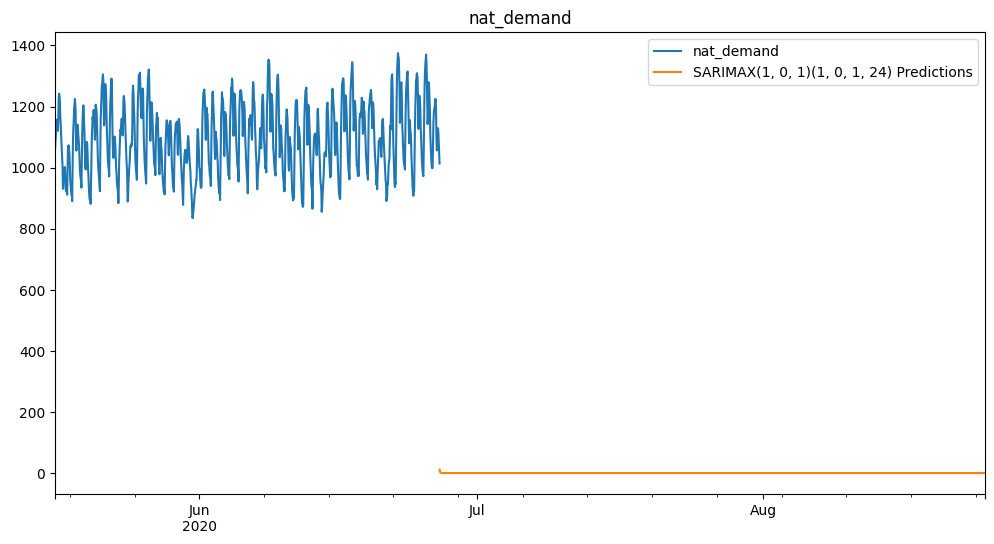

In [240]:
# Plot predictions against known values
title = 'nat_demand'
ylabel=''
xlabel=''

ax = test_data_exo['nat_demand'][-1000:].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);